# Contents

- [Strava API](#Strava-API)
    - [Swagger Client](#Swagger-Client)
    - [Getting Over the Humps](#Getting-Over-the-Humps)
    - [Test Working](#Test-WOrking)
- [List Activites](#List-Activities)
- [Conversion](#Conversion)
- [Preview](#Preview)
- [Data Dump](#Data-Dump)
    - [Write](#Write)
    - [Read](#Read)
- [Data Analysis](#Data-Analysis)
    - [Statistics](#Statistics)
    - [Plots](#Plots)
- [Geographic Data](#Geographic-Data)
    - [Matplotlib](#Matplotlib)
    - [Altair](#Altair)

# Strava API

The official Strava API docs are here https://developers.strava.com/docs/  
 
First go and create a free application to generate your access token. Go here https://www.strava.com/settings/api  

I have already done this and defined my access token as an environment variable, called `STRAVA_ACCESS_TOKEN`.  

In [2]:
import os

In [3]:
strava_access_token = os.environ['STRAVA_ACCESS_TOKEN']

## Swagger Client

You interface with Strava's API via [Swagger, and the OpenAPI Specification](https://swagger.io/docs/specification/about/).

Using a Swagger API comes with a few prequequisites, including the [Swagger CodeGen Command Line Interface (CLI)](https://github.com/swagger-api/swagger-codegen), and the [Java Runtime Environment (JRE)](https://www.oracle.com/technetwork/java/javase/downloads).  

To get the Swagger CLI on Windows, i did the following:
- create a folder where I am running this notebook, called `swagger`  
- from there, run the following command via `Windows PowerShell`   
```shell
Invoke-WebRequest -OutFile swagger-codegen-cli.jar http://central.maven.org/maven2/io/swagger/swagger-codegen-cli/2.3.1/swagger-codegen-cli-2.3.1.jar
```

After you have Swagger CodeGen and JRE installed, test everything is working with the following:  

```shell
# (Windows)
java -jar swagger/swagger-codegen-cli.jar help
```

Now you need to generate the Strava Swagger API locally to be able to use it. From within the resources folder, run the following command:  

```shell
# (Windows)
java -jar swagger-codegen-cli.jar generate -i https://developers.strava.com/swagger/swagger.json -l python
```

This will download the API specification as a Python library in a folder called `swagger_client`.  

We will temporarily add the `swagger` to our python `PATH` for making it available during the execution of this notebook only.

In [4]:
import sys
sys.path.append(os.path.abspath('swagger'))

In [5]:
import swagger_client

In [6]:
swagger_client.configuration.access_token = strava_access_token

## Getting Over the Humps

Surprisingly, this took a bit longer than I hoped to figure everything out. Here are a few issues I ran into and how to solve them.  

### Issue 1

The examples on Strava website assume your code is running from the same directory you generated the swagger API, where `swagger_client` can be a "relative import", otherwise you will need to add the `swagger_client` folder to your `Python PATH`.

### Issue 2

Bug in the Strava Python examples. If you are using Python 3 ignore this, but if you are using Python 2 the following code in the examples is incorrect.  

```python
from __future__ import print_statement
```

Change it to.  

```python
from __future__ import print_function
```

### Issue 3

Another bug in Strava Python examples.

You must define every API class before using it. And it appears that every time we instantiate a new module, it resets the access token to a empty string.  

Setting the access token at the client level, then providing the authenticated client with the following, also does not seem to work.  
```python
swagger_client.configuration.access_token = strava_access_token
api_instance = swagger_client.AthletesApi(api_client=swagger_client)
```

You can try and hardcode your access_token into the swagger `configuration.py`, and maybe this is what Strava assumes you do, but this is probably not a good idea.  

Alternatively it may be possible to provide the access token in `config.json` when building the swagger api with the `-c` keyword argument, but I could not get this to work.  

## Test Working

Okay, we got it working.

In [7]:
from swagger_client.rest import ApiException

In [8]:
api_instance = swagger_client.AthletesApi()

In [9]:
api_instance.api_client.configuration.access_token = strava_access_token

In [10]:
try: 
    r = api_instance.get_logged_in_athlete()
except ApiException as e:
    print(e)

In [11]:
athlete_id = r.id
print(athlete_id)

2164216


In [12]:
print(r.follower_count)
print(r.friend_count)
print(round(r.follower_count / r.friend_count,2))

40
58
0.69


In [13]:
[(x.name, x.country) for x in r.clubs]

[('Monkeys On Bikes', 'United States'), ('Ride for Nokor Tep', 'Singapore')]

In [14]:
r.shoes

[{'distance': 820969.0,
  'id': 'g187719',
  'name': 'Nike',
  'primary': True,
  'resource_state': 2}]

In [15]:
r.bikes

[{'distance': 787999.0,
  'id': 'b892090',
  'name': "GF 29'er",
  'primary': True,
  'resource_state': 2}, {'distance': 855093.0,
  'id': 'b892097',
  'name': 'Sweet Felt',
  'primary': False,
  'resource_state': 2}]

# List Activities

Let's get all my activities, using pagination, at 30 activites per page. **If you know you have A LOT of activities, you should probably set some limit here.**

In [15]:
api_instance = swagger_client.ActivitiesApi()
api_instance.api_client.configuration.access_token = strava_access_token

results = []
i = 1
while True:
    print('page:',i)
    activities = api_instance.get_logged_in_athlete_activities(page=i, per_page=30)
    if activities:
        results.append(activities)
        i+=1
    else:
        break

page: 1
page: 2
page: 3
page: 4
page: 5
page: 6
page: 7
page: 8


# Conversion

In [16]:
# flatten the list of lists
activities = [a for r in results for a in r]

In [17]:
# convert each Strava Activity Object to Python dictionary for more general use
records = [a.to_dict() for a in activities]

In [18]:
len(activities)

185

In [19]:
len(records)

185

# Data Dump

We should backup the data on disk, in case we want to use it later without needing to call the API again.  

**NOTE:** Since the data contains properties of type `datetime`, and Python does not know what to do with these when converting a `dict` to `json` string, we define two functions to "serialize" and "deserialize" the types to ISO format during read/write.  

## Write

In [21]:
import json
from datetime import datetime

class datetime2iso(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, datetime):
            return obj.isoformat()
        else:
            return json.JSONEncoder.default(self, obj)

In [22]:
with open('data/strava_activites.json', 'w+') as f:
    for d in records:
        f.write(json.dumps(d, cls=datetime2iso))
        f.write('\n')

## Read

In [16]:
import json
import dateutil

def iso2datetime(obj):
    d = {}
    for k,v in obj:
        if isinstance(v, str):
            try:
                d[k] = dateutil.parser.parse(v)
            except ValueError:
                d[k] = v
        else:
            d[k] = v
    return d

In [18]:
records = []
with open('data/strava_activites.json', 'r') as f:
    for d in f.readlines():
        records.append(json.loads(d, object_pairs_hook=iso2datetime))

# Preview

In [19]:
len(records)

185

In [20]:
records[1]

{'id': 2199821385,
 'external_id': '905e78fcaec8828d8fa0e7e645caeeef',
 'upload_id': 2343841696,
 'athlete': {'id': 2164216},
 'name': 'Soccer Practice (10v10 full field, right mid)',
 'distance': 6659.7,
 'moving_time': 3051,
 'elapsed_time': 4532,
 'total_elevation_gain': 0.0,
 'elev_high': 5.5,
 'elev_low': 4.4,
 'type': 'Run',
 'start_date': datetime.datetime(2019, 3, 8, 18, 27, 19, tzinfo=tzutc()),
 'start_date_local': datetime.datetime(2019, 3, 8, 19, 27, 19, tzinfo=tzutc()),
 'timezone': '(GMT+01:00) Europe/Amsterdam',
 'start_latlng': [52.17, 4.46],
 'end_latlng': [52.17, 4.46],
 'achievement_count': 0,
 'kudos_count': 2,
 'comment_count': 0,
 'athlete_count': 1,
 'photo_count': 0,
 'total_photo_count': 0,
 'map': {'id': 'a2199821385',
  'polyline': None,
  'summary_polyline': 'i{k}HysfZ@}BaAzBf@aBPtDUmDQdBx@ROcBc@dAVcC[tDVeDf@~A{@l@?oCl@Ao@nD?_CIbBz@mAu@MGzBFaCv@vAm@LNgDJ~Bq@At@Zg@sCLdEb@iAy@xBx@oH\\pCy@zA]_DtA\\m@z@@{BgAzC~@?SaB^lCe@eF@hE~@WQ_Bk@~BRoB\\xAQ}DWvFb@sDJfC[}DWlEj@

# Data Analysis

Let's quickly bring this into Pandas to get summarize the data.  

Using the definitions provided by Strava [here on Detailed Activity Model](https://developers.strava.com/docs/reference/#api-models-DetailedActivity).  

In [21]:
import pandas as pd

In [22]:
df = pd.DataFrame.from_records(records)

In [23]:
df.shape

(185, 39)

### Preview

In [24]:
df.head(2)

,achievement_count,athlete,athlete_count,average_speed,average_watts,comment_count,commute,device_watts,distance,elapsed_time,...,start_date_local,start_latlng,timezone,total_elevation_gain,total_photo_count,trainer,type,upload_id,weighted_average_watts,workout_type
0,0,{'id': 2164216},1,3.333,NaN,0,False,None,6200.0,1860,...,2019-03-09 10:30:06+00:00,None,(GMT-06:00) America/Chicago,0.0,1,False,Run,NaN,None,3.0
1,0,{'id': 2164216},1,2.183,NaN,0,False,None,6659.7,4532,...,2019-03-08 19:27:19+00:00,"[52.17, 4.46]",(GMT+01:00) Europe/Amsterdam,0.0,0,False,Run,2.343842e+09,None,3.0


### Conversions

In [25]:
# convert distance in meters to kilometers
df.loc[:,'distance'] = df.distance / 1000

# convert moving in seconds time to minutes
df.loc[:,'moving_time'] = df.moving_time / 60

# convert average speed in meters per second to minutes per kilometer
df.loc[:,'average_speed_mpk'] = 16.666 / df.average_speed

# create new column average speed in kilometers per hour
df.loc[:,'average_speed_kph'] = 60 / df.average_speed_mpk

### Formatting

In [26]:
# format date to be used in plot labels
df.loc[:,'start_date_formatted'] = df.start_date.dt.strftime('%b %Y')
df.loc[:,'start_date_year'] = df.start_date.dt.year
df.loc[:,'start_date_month'] = df.start_date.dt.month
df.loc[:,'start_date_weekday'] = df.start_date.dt.weekday

## Statistics

In [27]:
df.type.value_counts()

Run          143
Ride          39
Hike           2
AlpineSki      1
Name: type, dtype: int64

In [28]:
df.groupby('type')\
    [['average_speed_mpk',
      'average_speed_kph',
      'distance','moving_time',
      'total_elevation_gain',
      'achievement_count']]\
    .agg(['mean','max'])\
    .T

type                       AlpineSki        Hike         Ride         Run
average_speed_mpk    mean   2.662300   11.130909     2.971732    5.683848
                     max    2.662300   14.159728     6.864086    7.861321
average_speed_kph    mean  22.536901    5.821433    21.331315   10.670046
                     max   22.536901    7.405496    27.739110   13.500540
distance             mean   6.348000    7.263100    51.181644    5.953995
                     max    6.348000    9.464000   121.092000   12.309700
moving_time          mean  16.900000   74.175000   143.432479   33.897319
                     max   16.900000   76.666667   341.583333   85.733333
total_elevation_gain mean   3.600000  209.700000   268.182051   24.373427
                     max    3.600000  405.100000  1370.300000  393.000000
achievement_count    mean   0.000000    0.000000     7.974359    1.342657
                     max    0.000000    0.000000    40.000000    9.000000

In [29]:
df.groupby('timezone').type.value_counts().to_frame()

type
timezone                      type           
(GMT+01:00) Europe/Amsterdam  Run          83
                              Ride          9
                              Hike          1
(GMT+01:00) Europe/Vienna     AlpineSki     1
(GMT+08:00) Asia/Kuala_Lumpur Hike          1
                              Run           1
(GMT+08:00) Asia/Singapore    Ride          9
                              Run           1
(GMT-06:00) America/Chicago   Run          58
                              Ride         21

## Plots

For visualizations in this notebook i am using a library called Altair. For more on that see https://altair-viz.github.io/

In [1]:
import altair as alt
print(alt.__version__)
alt.renderers.enable('default')
print(alt.renderers.active)

2.2.2
default


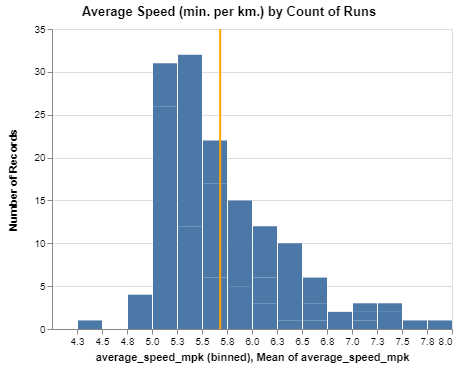

In [31]:
data = df.loc[df.type=='Run',:][['id','start_date_formatted','average_speed_mpk']]
data.loc[:,'average_speed_mpk'] = data.average_speed_mpk.apply(lambda d: round(d,1))

bar = alt.Chart(data).mark_bar().encode(
    alt.X('average_speed_mpk:Q', bin=alt.Bin(step=.25)),
    alt.Y('count()'),
    tooltip=['average_speed_mpk:Q','count()']
)

bar.title = 'Average Speed (min. per km.) by Count of Runs'

rule = alt.Chart(data).mark_rule(color='orange').encode(
    x='mean(average_speed_mpk):Q',
    size=alt.value(2)
)

alt.layer(
    bar,
    rule
).interactive()

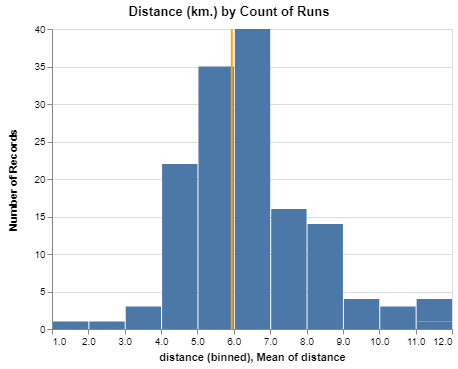

In [32]:
data = df.loc[df.type=='Run',:][['id','start_date_formatted','distance']]
data.loc[:,'distance'] = data.distance.apply(lambda d: round(d))

bar = alt.Chart(data).mark_bar().encode(
    alt.X('distance:Q', bin=alt.Bin(step=1)),
    alt.Y('count()'),
    tooltip=['distance:Q','count()']
)

bar.title = 'Distance (km.) by Count of Runs'

rule = alt.Chart(data).mark_rule(color='orange').encode(
    x='mean(distance):Q',
    size=alt.value(2)
)

alt.layer(
    bar,
    rule
).interactive()

C:\Users\Kain\Anaconda3\lib\site-packages\altair\utils\core.py:284: FutureWarning: A future version of pandas will default to `skipna=True`. To silence this warning, pass `skipna=True|False` explicitly.
  attrs['type'] = infer_vegalite_type(data[attrs['field']])


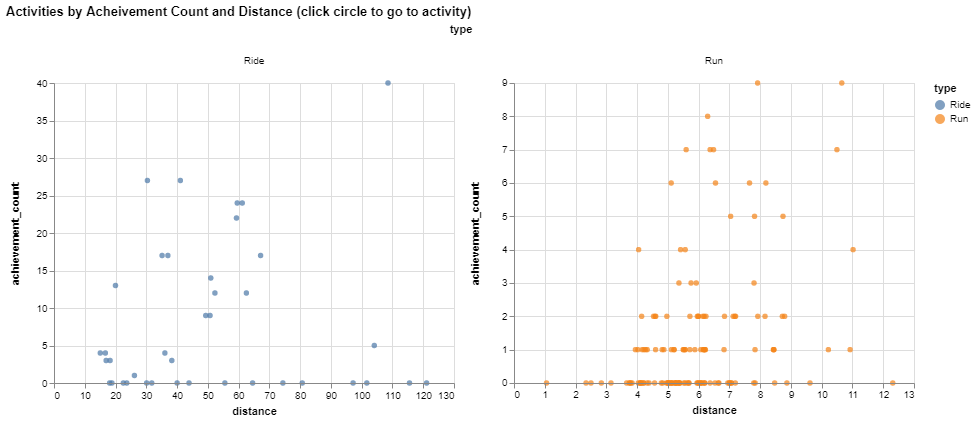

In [33]:
data = df.loc[df['type'].isin(['Run','Ride']),:]
data = data[['id','start_date_formatted','type','distance','achievement_count']]

chart = alt.Chart(data).transform_calculate(
    url='https://www.strava.com/activities/' + alt.datum.id
).mark_circle().encode(
    x='distance',
    y='achievement_count',
    color='type',
    href='url:N',
    tooltip=['start_date_formatted','distance','achievement_count','url:N']
).facet(
    column='type'
).resolve_scale(
    x='independent',
    y='independent'
)

chart.title = 'Activities by Acheivement Count and Distance (click circle to go to activity)'

chart

C:\Users\Kain\Anaconda3\lib\site-packages\altair\utils\core.py:284: FutureWarning: A future version of pandas will default to `skipna=True`. To silence this warning, pass `skipna=True|False` explicitly.
  attrs['type'] = infer_vegalite_type(data[attrs['field']])


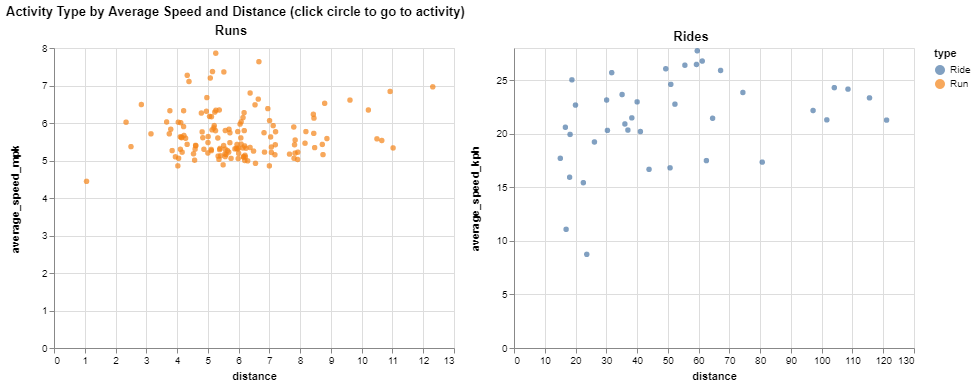

In [34]:
data_run = df.loc[df['type'] == 'Run',:]
data_run = data_run[['id','start_date_formatted','type','distance','average_speed_mpk']]

chart_run = alt.Chart(data_run).transform_calculate(
    url='https://www.strava.com/activities/' + alt.datum.id
).mark_circle().encode(
    x='distance',
    y='average_speed_mpk',
    color='type',
    href='url:N',
    tooltip=['start_date_formatted','distance','average_speed_mpk','url:N']
).interactive()

chart_run.title = 'Runs'

data_ride = df.loc[df['type'] == 'Ride',:]
data_ride = data_ride[['id','start_date_formatted','type','distance','average_speed_kph']]

chart_ride = alt.Chart(data_ride).transform_calculate(
    url='https://www.strava.com/activities/' + alt.datum.id
).mark_circle().encode(
    x='distance',
    y='average_speed_kph',
    color='type',
    href='url:N',
    tooltip=['start_date_formatted','distance','average_speed_kph','url:N']
).interactive()

chart_ride.title = 'Rides'

chart = alt.hconcat(chart_run, chart_ride)

chart.title = 'Activity Type by Average Speed and Distance (click circle to go to activity)'

chart

C:\Users\Kain\Anaconda3\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\Kain\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\Kain\Anaconda3\lib\site-packages\altair\utils\core.py:284: FutureWarning: A future version of pandas will default to `skipna=True`. To silence this warning, pass `skipna=True|False` explicitly.
  attrs['type'] = infer_vegalite_type(data[attrs[

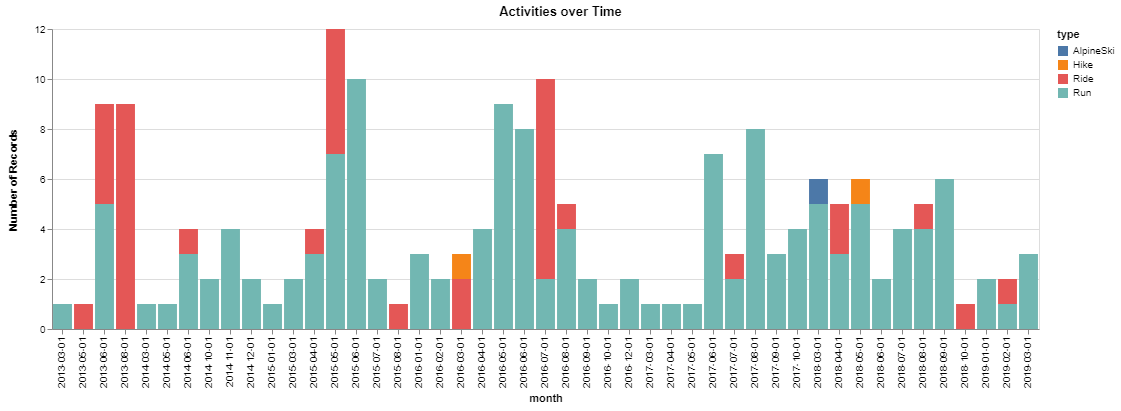

In [35]:
data = df[['id','type','start_date','distance','moving_time']]
data.loc[:,'month'] = data.start_date.dt.strftime('%Y-%m-01')

chart = alt.Chart(data).mark_bar().encode(
    x='month',
    y='count(id)',
    color='type',
    tooltip=['month','type','count(id)']
).interactive()

chart.title = 'Activities over Time'

chart

C:\Users\Kain\Anaconda3\lib\site-packages\altair\utils\core.py:284: FutureWarning: A future version of pandas will default to `skipna=True`. To silence this warning, pass `skipna=True|False` explicitly.
  attrs['type'] = infer_vegalite_type(data[attrs['field']])


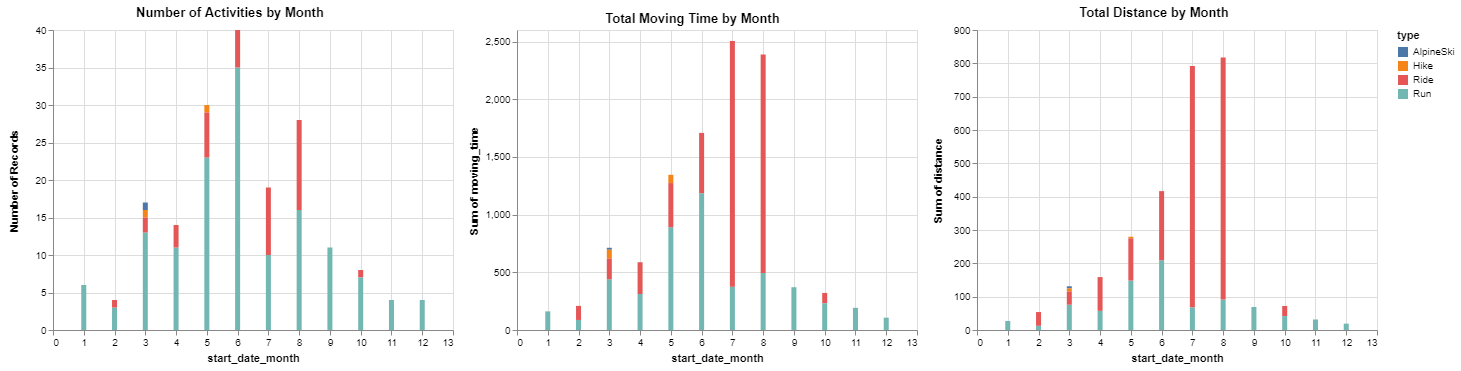

In [36]:
data = df[['id','type','start_date_month','moving_time','distance']]

chart_activities = alt.Chart(data).mark_bar().encode(
    x='start_date_month',
    y='count(id)',
    color='type',
    tooltip=['start_date_month','type','count(id)']
).interactive()

chart_time = alt.Chart(data).mark_bar().encode(
    x='start_date_month',
    y='sum(moving_time)',
    color='type',
    tooltip=['start_date_month','type','sum(moving_time)']
).interactive()

chart_distance = alt.Chart(data).mark_bar().encode(
    x='start_date_month',
    y='sum(distance)',
    color='type',
    tooltip=['start_date_month','type','sum(distance)']
).interactive()

chart_activities.title = 'Number of Activities by Month'
chart_time.title = 'Total Moving Time by Month'
chart_distance.title = 'Total Distance by Month'

chart = alt.hconcat(chart_activities, chart_time, chart_distance)

chart

C:\Users\Kain\Anaconda3\lib\site-packages\altair\utils\core.py:284: FutureWarning: A future version of pandas will default to `skipna=True`. To silence this warning, pass `skipna=True|False` explicitly.
  attrs['type'] = infer_vegalite_type(data[attrs['field']])


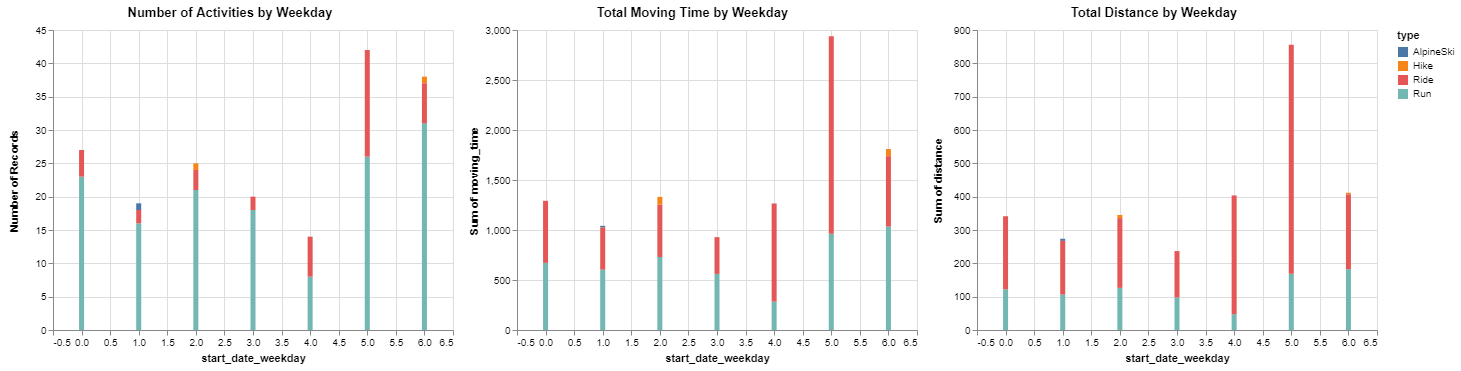

In [37]:
data = df[['id','type','start_date_weekday','moving_time','distance']]

chart_activities = alt.Chart(data).mark_bar().encode(
    x='start_date_weekday',
    y='count(id)',
    color='type',
    tooltip=['start_date_weekday','type','count(id)']
).interactive()

chart_time = alt.Chart(data).mark_bar().encode(
    x='start_date_weekday',
    y='sum(moving_time)',
    color='type',
    tooltip=['start_date_weekday','type','sum(moving_time)']
).interactive()

chart_distance = alt.Chart(data).mark_bar().encode(
    x='start_date_weekday',
    y='sum(distance)',
    color='type',
    tooltip=['start_date_weekday','type','sum(distance)']
).interactive()

chart_activities.title = 'Number of Activities by Weekday'
chart_time.title = 'Total Moving Time by Weekday'
chart_distance.title = 'Total Distance by Weekday'

chart = alt.hconcat(chart_activities, chart_time, chart_distance)

chart

# Geographic Data

Strava provides here a summarized version of each activity. As well the route map is summarized as a simple list of latitue and longitude coordinates, and encoded using [Google's Polyline Algorithm](https://developers.google.com/maps/documentation/utilities/polylinealgorithm).

Handy enough, there is a [polyline library in Python](https://github.com/hicsail/polyline) which we can use to decode this. Get it with `pip install polyline`

In [38]:
import polyline

In [39]:
coo = polyline.decode(records[1]['map']['summary_polyline'])

In [40]:
coo[:10]

[(52.16709, 4.46285),
 (52.16708, 4.46348),
 (52.16741, 4.46286),
 (52.16721, 4.46335),
 (52.16712, 4.46244),
 (52.16723, 4.46331),
 (52.16732, 4.4628),
 (52.16703, 4.4627),
 (52.16711, 4.4632),
 (52.16729, 4.46285)]

Now we can apply basic plotting techniques to represent the coordinates geographically, to get something that looks similar to https://www.strava.com/heatmap. **Just an FYI, viewing personal heatmaps in Strava is a paid feature(!)**  

A simple way to do this in Python is start with a basic Matplotlib canvas.  

Since the activies are so far unfiliterd, and I know I have recorded activies in various parts of the world, let's apply some basic filtering to get valid activity coordinates from general geographic locations of interest (using rounding of coordincates).

I'm not going to show too many details here, and adding backgrounds to maps is complicated. However, this can be personally very interesting to see which neighborhoods or routes you favor over others by just glancing this over.

## Matplotlib

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### Des Moines, IA USA

In [42]:
coo_list = [polyline.decode(x['map']['summary_polyline']) for x in records
            if x['timezone'] == '(GMT-06:00) America/Chicago'
            and x['start_latlng'] is not None
            and x['start_latlng'][0] <= 41.6 and round(x['start_latlng'][0],1) >= 41.2 and round(x['start_latlng'][1]) == -94]

In [43]:
print('Activities:', len(coo_list))

Activities: 56


In [44]:
coo_list[0]

[(41.56645, -93.76034),
 (41.56754, -93.75875),
 (41.56758, -93.75443),
 (41.5681, -93.75286),
 (41.5688, -93.75212),
 (41.56851, -93.75168),
 (41.56985, -93.75027),
 (41.56975, -93.7491),
 (41.5708, -93.74901),
 (41.57216, -93.75091),
 (41.57268, -93.75614),
 (41.57027, -93.75634),
 (41.5704, -93.75972),
 (41.56903, -93.75985),
 (41.56763, -93.75855),
 (41.56671, -93.76006),
 (41.56015, -93.76562),
 (41.55941, -93.76774)]

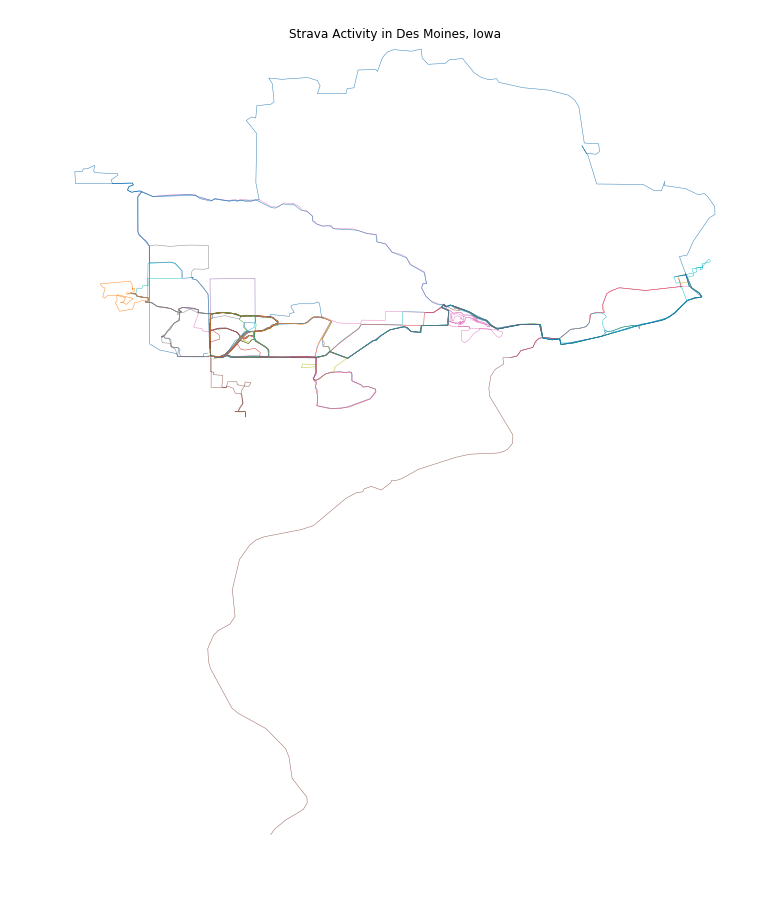

In [45]:
fig = plt.figure(figsize=(12,12))
fig.suptitle('Strava Activity in Des Moines, Iowa')
ax = plt.Axes(fig, [0., 0., 1., 1.], )
ax.set_aspect('equal')
ax.set_axis_off()
fig.add_axes(ax)

for coo in coo_list:
    lat,lon = map(list, zip(*coo))
    plt.plot(lon, lat, lw=0.5, alpha=.9)

## Altair

## (Vega Lite / D3)

To do the same thing in Altair, we need to get the data into a format required by d3, preferably the compressed geo file format `topojson`.  

The steps taken are then the following:
1. Transform data in Python using
    - decode the polylines into list of longitute latitude
    - convert list of longitute latitude to list of `Shapely` Points
    - convert list of points into `Shapely` LineStrings
    - convert `Pandas` DataFrame with LineStrings and metadata to `GeoPandas` DataFrame
2. Export as `GeoJson`
3. Convert `GeoJSON` to `TopoJSON` using `geo2topo`
```shell
geo2topo -q 1e6 line=geojson.json > topojson.json
```
4. Import topojson into `Altair` and plot

Requirements:
- GeoPandas and dependencies http://geopandas.org/install.html
- TopoJSON Server https://github.com/topojson/topojson-server#installing

Caveats:
- at time of writing we cannot add hover tooltips in Altair because Vega Lite does not yet support interactive geoshapes (follow the issue here https://github.com/altair-viz/altair/issues/679)

Background Reading:
- for more on how D3 uses TopoJSON read Mike Bostock's [Command Line Cartography](https://medium.com/@mbostock/command-line-cartography-part-1-897aa8f8ca2c) (formerly [Let's Make a Map](https://bost.ocks.org/mike/map/))

In [46]:
from geopandas import GeoDataFrame
from shapely.geometry import Point, LineString

def decode_map(x):
    if not x['summary_polyline'] == None:
        return polyline.decode(x['summary_polyline'])

### Des Moines, IA USA

In [47]:
df_tmp = df.loc[df.timezone == '(GMT-06:00) America/Chicago',:]
df_tmp = df_tmp.loc[df.start_latlng.apply(lambda x: round(x[0],1) <= 41.6  and round(x[0],1) >= 41.2 and round(x[1]) == -94 if not x == None else False),:]

In [48]:
df_tmp.loc[:,'map_decoded'] = df_tmp.loc[:,'map'].apply(decode_map)

df_tmp.loc[:,'geometry_list'] = df_tmp.loc[:,'map_decoded'].apply(lambda d: [Point(y,x) for x,y in d] if not d == None else pd.np.nan)

df_map = df_tmp.loc[df_tmp.geometry_list.isnull() == False,:]

df_map.loc[:,'geo_line'] = df_map.loc[:,'geometry_list'].apply(LineString)

gdf = GeoDataFrame(df_map[['id','start_date_formatted','type','geo_line']], geometry='geo_line')

In [49]:
gdf.head()

,id,start_date_formatted,type,geo_line
6,2060397406,Jan 2019,Run,"LINESTRING (-93.76034 41.56645, -93.7587500000..."
67,984934815,May 2017,Run,"LINESTRING (-93.76942 41.55954, -93.7675299999..."
70,817262248,Dec 2016,Run,"LINESTRING (-93.76782 41.55941, -93.7664099999..."
71,815054880,Dec 2016,Run,"LINESTRING (-93.77070000000001 41.56226, -93.7..."
75,672812022,Aug 2016,Run,"LINESTRING (-93.76779000000001 41.5594, -93.76..."


In [51]:
gdf.to_file('public_data/geojson.json', driver="GeoJSON")

#### now run below command to generate topojson file

```shell
geo2topo -q 1e6 line=geojson.json > topojson.json
```

In [2]:
data = alt.topo_feature('https://knanne.github.io/notebooks/jupyter/public_data/topojson.json', 'line')

In [3]:
data

UrlData({
  format: TopoDataFormat({
    feature: 'line',
    type: 'topojson'
  }),
  url: 'https://knanne.github.io/notebooks/jupyter/public_data/topojson.json'
})

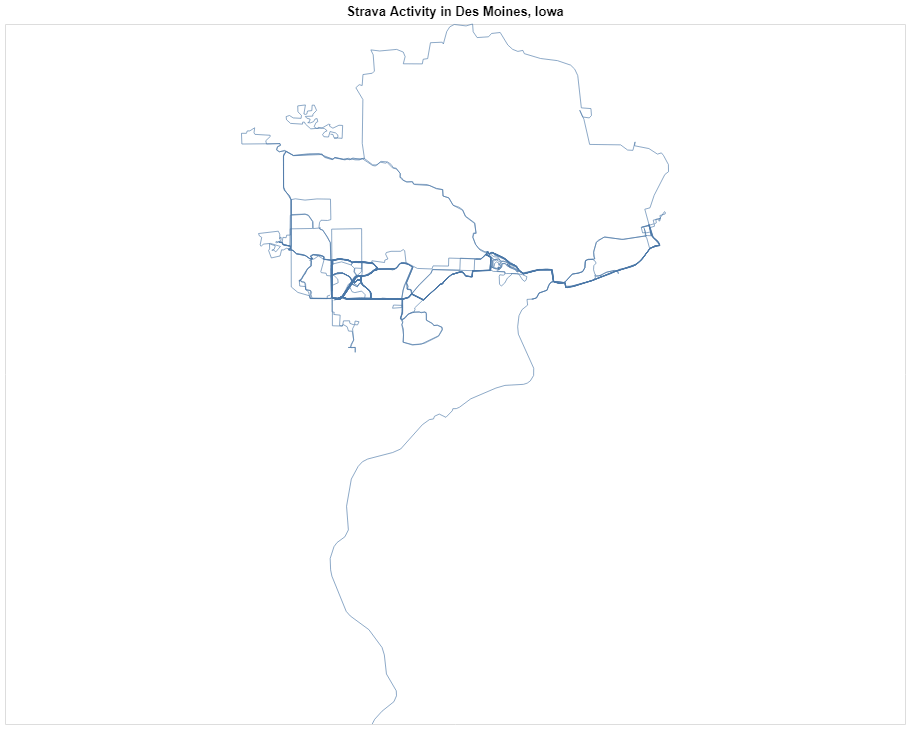

In [5]:
chart = alt.Chart(data).mark_geoshape(
    strokeWidth=.7,
    opacity=.9,
    filled=False
).properties(
    title='Strava Activity in Des Moines, Iowa',
    width=900,
    height=700
)

chart